# Maximin LinUCB

In [1]:
from lrcb.bandits.multirep_finite import FiniteMultiBandit, hls_rank_combined
from lrcb.representations.finite_representations import make_random_rep, hls_rank, rank, derank_hls, make_hls_rank
from lrcb.representations.finite_representations import is_cmb, is_hls, spans, hls_lambda, derank_cmb, LinearRepresentation
from lrcb.representations.finite_representations import reduce_dim, fuse_columns
from lrcb.algos.oful import oful
from lrcb.algos.lr_oful import select_oful
from lrcb.algos.maximin_oful import maximin_oful
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lrcb.visualization.notebook_utils as nu
from jupyterthemes import jtplot
#jtplot.style()
plt.rcParams['figure.figsize'] = [12, 9]

## Common settings

In [2]:
nc = 100
na = 5
dim = 20
noise = 0.1
seeds = range(5)

Generate original HLS representation

In [3]:
r0 = make_random_rep(nc, na, dim, normalize=True)
assert is_hls(r0)

OFUL settings

In [4]:
iterations = 10000
reg = 0.1
delta = 0.1
param_bound = 1. #Guaranteed by make_random_rep(..., normalize=True)

## Comparison of different strategies

Basic problem: 20 equivalent representations of dimension 20, of increasing hls rank, only one is HLS (the last)

In [5]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    
#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

**oracle**: OFUL on HLS representation

In [6]:
problem.select_rep(-1)
for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='basic_oracle')

**dummy**: OFUL on non-HLS representation (rank d-1) as a reference

In [7]:
problem.select_rep(-2)
for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='basic_dummy')

For model-selection algorithm, start from random active representation and divide confidence by n. reps.

In [8]:
problem.reset()
delta2 = delta / len(reps)

**lambdamin(u)**: select representation with largest minimum eigenvalue of optimal features according to uniform distribution and estimated optimal actions

In [9]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=True,
                seed=seed, verbose=False, logname='basic_lambdamin(u)')

**lambdamin**: same with empirical context distribution

In [10]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=False,
                seed=seed, verbose=False, logname='basic_lambdamin')

**design**: select representation with largest minimum eigenvalue of design matrix

In [11]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='design', uniform=False,
                seed=seed, verbose=False, logname='basic_design')

**minbonus**: select representation with minimum optimistic bonus

In [12]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='minbonus', uniform=False,
                seed=seed, verbose=False, logname='basic_minbonus')

**maximin**: use the tightest UCB for each arm

In [13]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
                seed=seed, verbose=False, logname='basic_maximin')

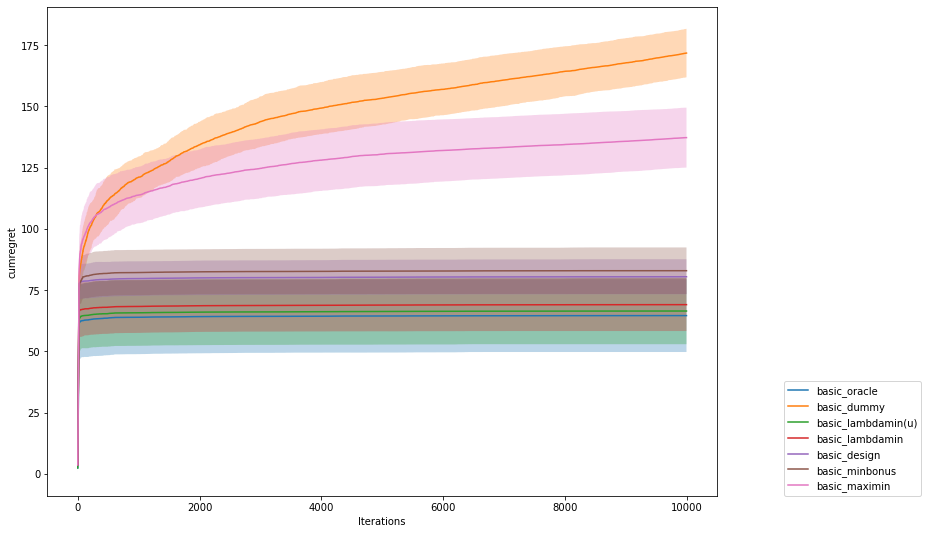

In [14]:
nu.compare('../logs', ['basic_oracle', 'basic_dummy', 'basic_lambdamin(u)', 'basic_lambdamin', 'basic_design',
                      'basic_minbonus', 'basic_maximin'], 'cumregret', seeds)

## Effect of the Number of Representations

In [15]:
values = [2, 4, 8, 16, 32]
for n_reps in values:
    reps = [r0]
    for _ in range(n_reps - 1):
        reps.append(derank_hls(r0, dim-1, transform=True, normalize=True))
    problem = FiniteMultiBandit(nc, na, reps)
    problem.reset()
    delta2 = delta / n_reps
    for seed in seeds:
        maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
            seed=seed, verbose=False, logname='nreps(%d)_maximin' % n_reps)

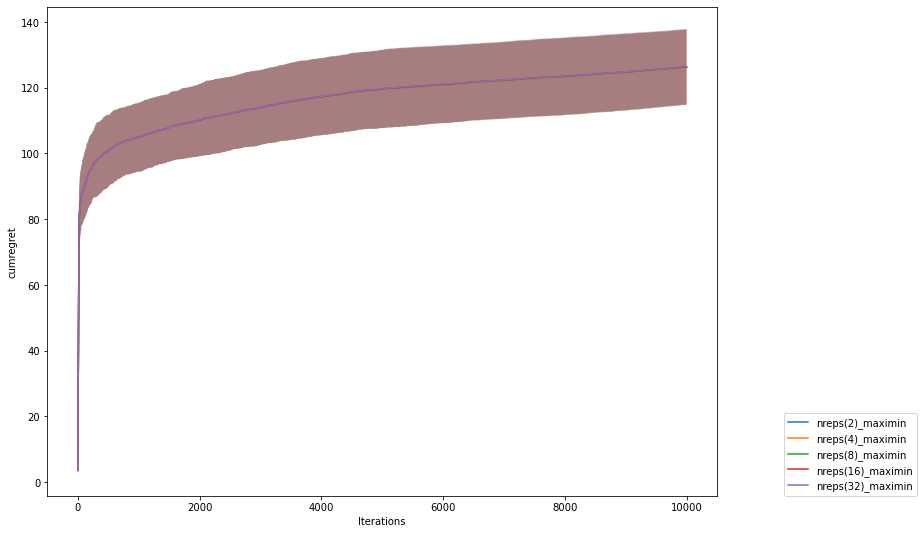

In [16]:
nu.compare('../logs', ['nreps(%d)_maximin' % i for i in values], 'cumregret', seeds)

## Varying Dimension

In [17]:
values = range(2, 20)
reps = []
for dim in values:
    r = reduce_dim(r0, dim, transform=True, normalize=True)
    r = derank_hls(r, r.dim - 1)
    assert r==r0
    assert r.dim == dim
    
    reps.append(r)
r = derank_hls(r0, r0.dim - 1, transform=True, normalize=True)
reps.append(r)

reps.append(r0)

for r in reps:
    print('%d: %d' % (r.dim, hls_rank(r)))

problem = FiniteMultiBandit(nc, na, reps)

2: 1
3: 2
4: 3
5: 4
6: 5
7: 6
8: 7
9: 8
10: 9
11: 10
12: 11
13: 12
14: 13
15: 14
16: 15
17: 16
18: 17
19: 18
20: 19
20: 20


In [18]:
for i in range(len(reps)):
    problem.select_rep(i)
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, 
             logname='dims_oful%d' % hls_rank(reps[i]))

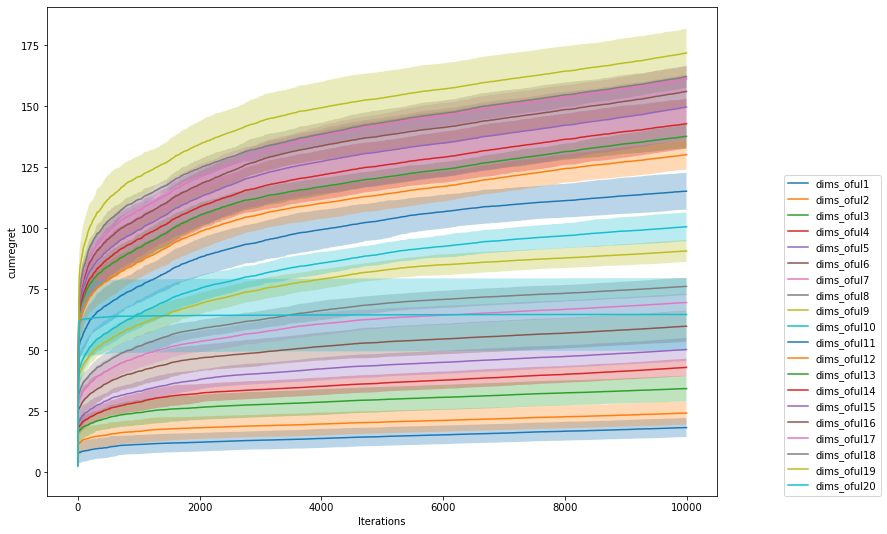

In [19]:
nu.compare('../logs', ['dims_oful%d' % d for d in range(1, 21)], 'cumregret', seeds)

In [20]:
ranking = nu.tournament('../logs', ['dims_oful%d' % d for d in range(1, 21)], 'cumregret', seeds)
best = ranking[0][0]
ranking

[('dims_oful1', 18.21240887794225),
 ('dims_oful2', 24.140992787171836),
 ('dims_oful3', 34.18371003327061),
 ('dims_oful4', 42.86438124251046),
 ('dims_oful5', 50.18610038478736),
 ('dims_oful6', 59.763713012140464),
 ('dims_oful20', 64.58413482703857),
 ('dims_oful7', 69.49756833186972),
 ('dims_oful8', 76.08749928227093),
 ('dims_oful9', 90.59163367828607),
 ('dims_oful10', 100.5012975948576),
 ('dims_oful11', 115.0922074646958),
 ('dims_oful12', 130.0925393752314),
 ('dims_oful13', 137.63715051513728),
 ('dims_oful14', 142.78117118804772),
 ('dims_oful15', 149.6176939865864),
 ('dims_oful16', 156.0081869577892),
 ('dims_oful17', 161.17593581050255),
 ('dims_oful18', 162.06318518446483),
 ('dims_oful19', 171.77236751826678)]

In [21]:
problem.reset()
delta2 = delta / len(reps)
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=True,
                seed=seed, verbose=False, logname='dims_lambdamin(u)')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=False,
                seed=seed, verbose=False, logname='dims_lambdamin')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='design', uniform=False,
                seed=seed, verbose=False, logname='dims_design')
    
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='minbonus', uniform=False,
                seed=seed, verbose=False, logname='dims_minbonus')
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
                seed=seed, verbose=False, logname='dims_maximin')

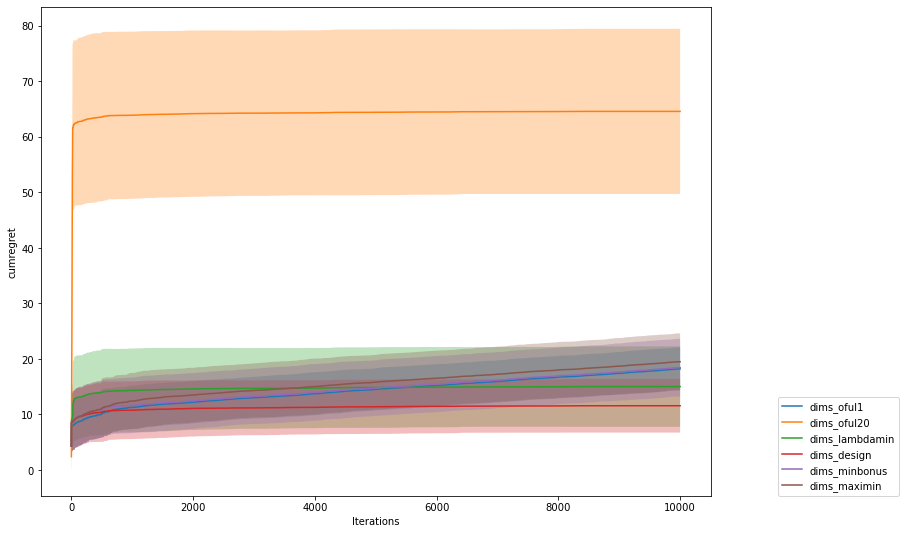

In [22]:
nu.compare('../logs', [best, 'dims_oful20', 'dims_lambdamin', 'dims_design',
                      'dims_minbonus', 'dims_maximin'], 'cumregret', seeds)

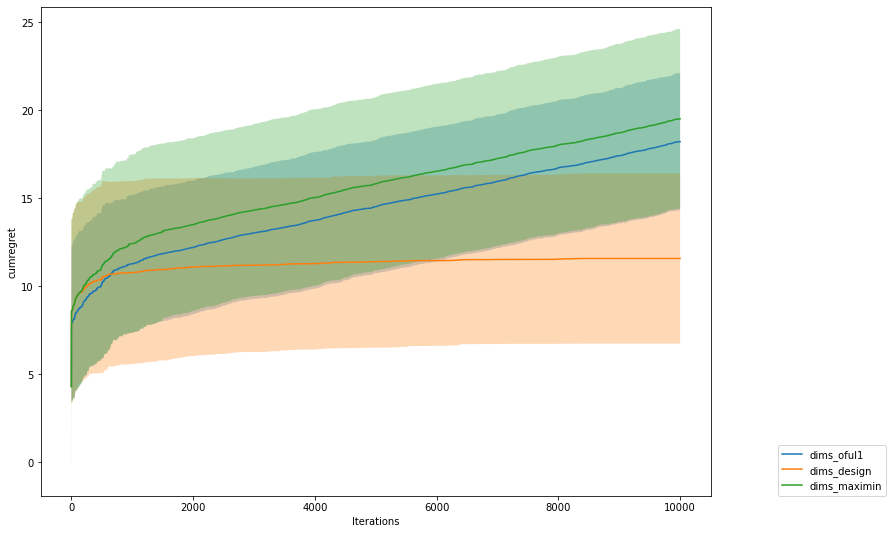

In [23]:
nu.compare('../logs', [best, 'dims_design', 'dims_maximin'], 'cumregret', seeds)

## Non-Uniform Contexts

Basic problem, but with non-uniform multinomial context distribution

In [24]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    
#Buldi multi-representation problem
cprobs = np.arange(1, nc+1)**2#np.random.uniform(size=nc)
cprobs = cprobs / np.sum(cprobs)
problem = FiniteMultiBandit(nc, na, reps, context_probs=cprobs)

<BarContainer object of 100 artists>

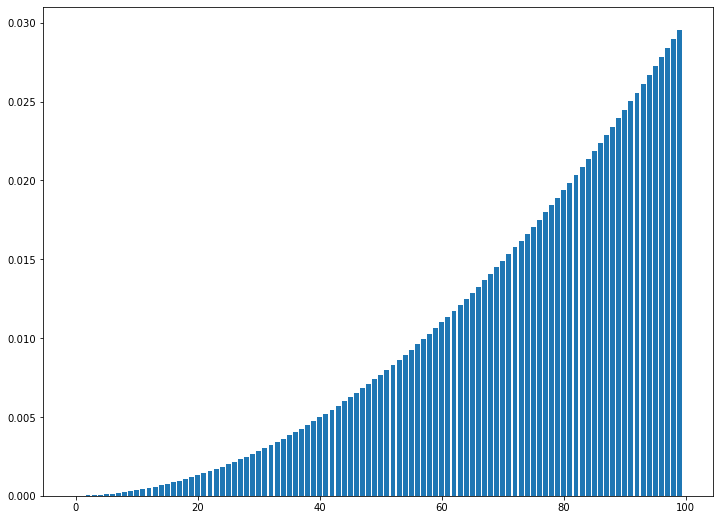

In [25]:
plt.bar(range(nc), cprobs)

In [26]:
hls_lambda(r0)

2.1374065000259086

In [27]:
hls_lambda(r0, cprobs)

1.7699093994431556

In [28]:
problem.select_rep(-1)
for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='context_oracle')

problem.select_rep(-2)
for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='context_dummy')

problem.reset()
delta2 = delta / len(reps)
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=True,
                seed=seed, verbose=False, logname='context_lambdamin(u)')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=False,
                seed=seed, verbose=False, logname='context_lambdamin')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='design', uniform=False,
                seed=seed, verbose=False, logname='context_design')
    
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='minbonus', uniform=False,
                seed=seed, verbose=False, logname='context_minbonus')
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
                seed=seed, verbose=False, logname='context_maximin')

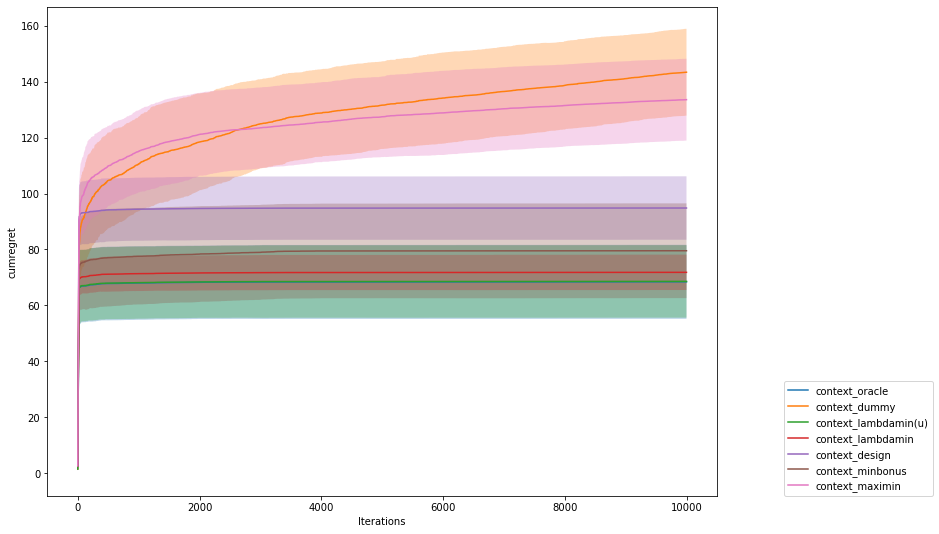

In [29]:
nu.compare('../logs', ['context_oracle', 'context_dummy', 'context_lambdamin(u)', 'context_lambdamin', 
                       'context_design','context_minbonus', 'context_maximin'], 'cumregret', seeds)

## Composing Representations

In [30]:
rA = fuse_columns(r0, 0, 1)
rB = fuse_columns(r0, 2, 3)

In [31]:
hls_rank(rA)

19

In [32]:
hls_rank(rB)

19

In [33]:
problem = FiniteMultiBandit(nc, na, (rA, rB))
hls_rank_combined(problem)

20

In [34]:
problem.select_rep(0)
for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='compose_ofulA')

problem.select_rep(1)
for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='compose_ofulB')

problem.reset()
delta2 = delta / 2
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=True,
                seed=seed, verbose=False, logname='compose_lambdamin(u)')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=False,
                seed=seed, verbose=False, logname='compose_lambdamin')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='design', uniform=False,
                seed=seed, verbose=False, logname='compose_design')
    
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='minbonus', uniform=False,
                seed=seed, verbose=False, logname='compose_minbonus')
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
                seed=seed, verbose=False, logname='compose_maximin')

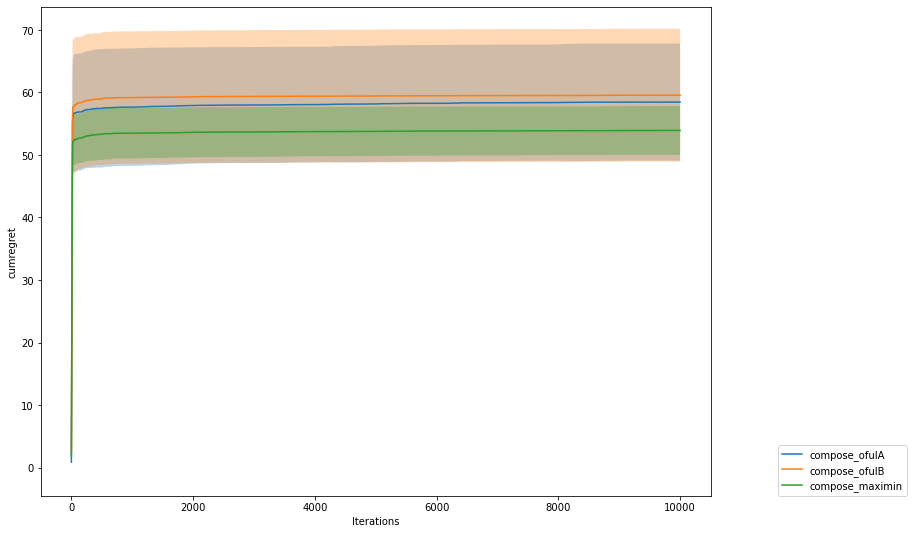

In [35]:
nu.compare('../logs', ['compose_ofulA', 'compose_ofulB', 'compose_maximin'], 'cumregret', seeds)